In [49]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima

In [50]:
import warnings

# Suppress only the sklearn/pmdarima FutureWarning about 'force_all_finite' being renamed
# to 'ensure_all_finite' (introduced in scikit-learn 1.6). This keeps teh notebook output
# clean while still allowing other warnings from pamdas/numpy/etc. to show up.
warnings.filterwarnings(
    action="ignore",
    category=FutureWarning,
    message=".*force_all_finite.*"
)

In [51]:
# Data ingestion
data = yf.download("AAPL", start="2018-01-01", end="2023-01-01", auto_adjust=True)["Close"]
data = data.asfreq("B", method="ffill")         # Business days frequency
data.head()

[*********************100%***********************]  1 of 1 completed


Ticker,AAPL
Date,
2018-01-02,40.380985
2018-01-03,40.373962
2018-01-04,40.561485
2018-01-05,41.023300
2018-01-08,40.870930


In [52]:
# Stationarity check
adf_pvalue = adfuller(data)[1]
print(f"ADF p-value: {adf_pvalue:.3f}")

ADF p-value: 0.735


In [53]:
# Auto ARIMA for best params
arima_model = auto_arima(data, seasonal=False, stepwise=True, suppress_warnings=True)
print(f"Best ARIMA: {arima_model.order}")

# Here, m=5 assumes a 5-business day seasonal cycle (weekly seasonality in trading days).
# Note: In financial time series, seasonality is often weak, so this is a modelling assumption
# rather than a gauranteed feature of the data
sarima_model = auto_arima(data, seasonal=True, m=5, stepwise=True, suppress_warnings=True)
print(f"Best SARIMA: {sarima_model.order}, Seasonal: {sarima_model.seasonal_order}")

Best ARIMA: (0, 1, 1)
Best SARIMA: (3, 1, 2), Seasonal: (2, 0, 0, 5)


In [54]:
# Train-Test split
train, test = data[:-60], data[-60:]

In [55]:
# Fit ARIMA
model_arima = SARIMAX(train, order=arima_model.order).fit(disp=False)
pred_arima = model_arima.get_forecast(steps=len(test)).predicted_mean

In [56]:
# Fit SARIMAX
model_sarima = SARIMAX(train, order=sarima_model.order, seasonal_order=sarima_model.seasonal_order).fit(disp=False)
pred_sarima = model_sarima.get_forecast(steps=(len(test))).predicted_mean

c:\Users\shanb\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [57]:
# Metrics
for name, pred in [("ARIMA", pred_arima), ("SARIMA", pred_sarima)]:
    rmse = np.sqrt(mean_squared_error(test, pred))
    mse = mean_absolute_error(test, pred)
    print(f"{name} -> RMSE: {rmse:.2f}, MAE: {mse:.2f}")

ARIMA -> RMSE: 7.29, MAE: 6.26
SARIMA -> RMSE: 7.17, MAE: 6.15


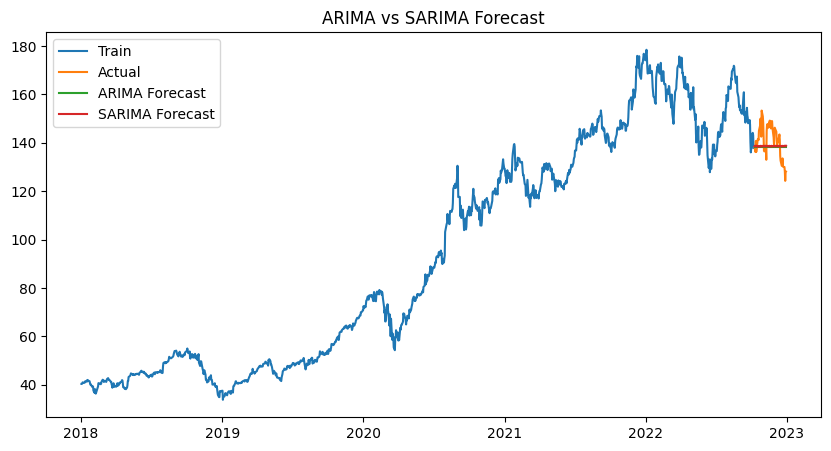

In [58]:
plt.figure(figsize=(10,5))
plt.plot(train, label="Train")
plt.plot(test, label="Actual")
plt.plot(pred_arima, label="ARIMA Forecast")
plt.plot(pred_sarima, label="SARIMA Forecast")
plt.legend()
plt.title("ARIMA vs SARIMA Forecast")
plt.show()